# Introduction

The purpose of this hands-on session istwo-fold: 

 * Explaining how to evaluate a quasi-analytical solution, that is singular of the pressureless gas dynamics
 
 * Show that once the solution is becoming singular, the dynamics of the singularity is not the one of the original

# General setting and smooth solution

We consider the following Cauchy problem:

$\rho(t, \mathbf{x})$, $\mathbf{u}(t, \mathbf{x})$ satisfying

\begin{equation}
    \left\{
    \begin{aligned}
    \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{u}) = 0 \\
    \frac{\partial \rho \mathbf{u}}{\partial t} + \nabla \cdot (\rho \mathbf{u} \mathbf{u} ) = 0
    \end{aligned}
    \right.
\end{equation}

with  $\rho(0, \mathbf{x}) = \rho_0(x) = 1$

\begin{equation}
    \left\{
        \begin{aligned}
            \mathbf{u}(0, x) = 0, \; x \in (-\infty, -1] \cup [-1, +\infty) \\
            \mathbf{u}(0, x) = 1 + x, \; x \in [-1, 0] \\
            \mathbf{u}(0, x) = 1 - x, \; x \in [0, 1]           
        \end{aligned}
    \right.    
\end{equation}

In [1]:
from ipywidgets import interact, IntSlider
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


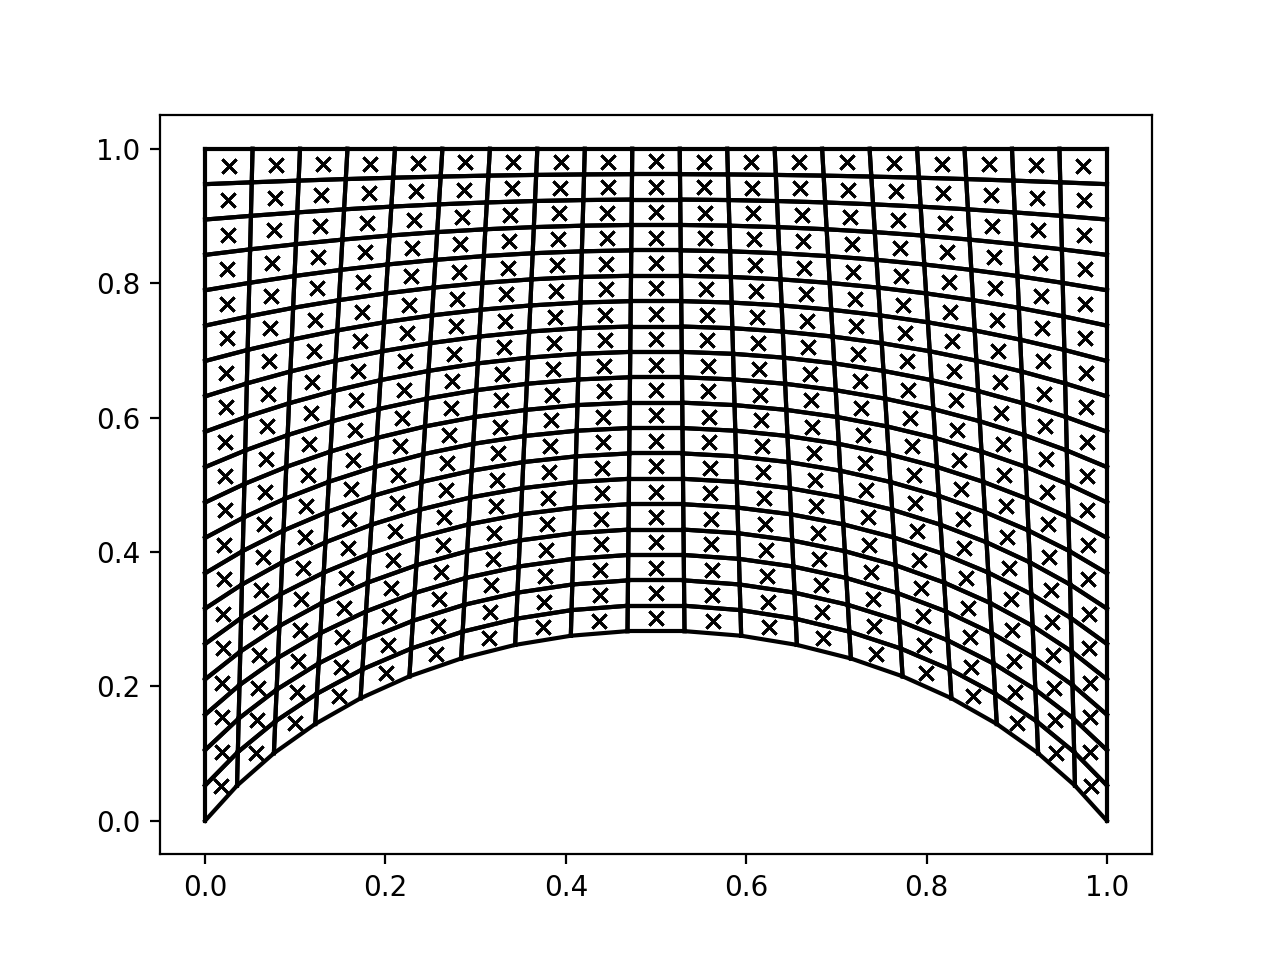

In [2]:
from josie.geom import CircleArc, Line
from josie.mesh import Mesh
from josie.bc import make_periodic, Direction

left = Line([0, 0], [0, 1])
bottom = CircleArc([0, 0], [1, 0], [0.2, 0.2])
# bottom = Line([0, 0], [1, 0])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])

left, right = make_periodic(left, right, Direction.X)
bottom, top = make_periodic(bottom, top, Direction.Y)

mesh = Mesh(left, bottom, right, top)
mesh.interpolate(20, 20)
mesh.generate()

mesh.plot()
plt.show()



In [3]:
import numpy as np

from josie.solver import Problem, StateTemplate, State, Solver
from josie.mesh import Cell

class Advection(Problem):
    Q = StateTemplate("u")
    V = np.array([1, 0])
    
    @classmethod
    def flux(cls, Q: State) -> State:
        return cls.V*Q
    
    
def init(cell: Cell) -> State: 
    xc, yc = cell.centroid
    
    if xc > 0.45:
        return Advection.Q(1)
    else:
        return Advection.Q(0)
    

    
def upwind(cell):
    Q = solver.problem.Q(0)
    for neigh in cell:
        norm = neigh.face.normal
        flux = Advection.flux
        S = neigh.face.surface

        un = Advection.V.dot(norm)

        if un >= 0:
            Q = Q + flux(cell.value).dot(norm)*S
        else:
            Q = Q + flux(neigh.value).dot(norm)*S

    return Q


solver = Solver(mesh, Advection)
solver.init(init)



<IPython.core.display.Javascript object>


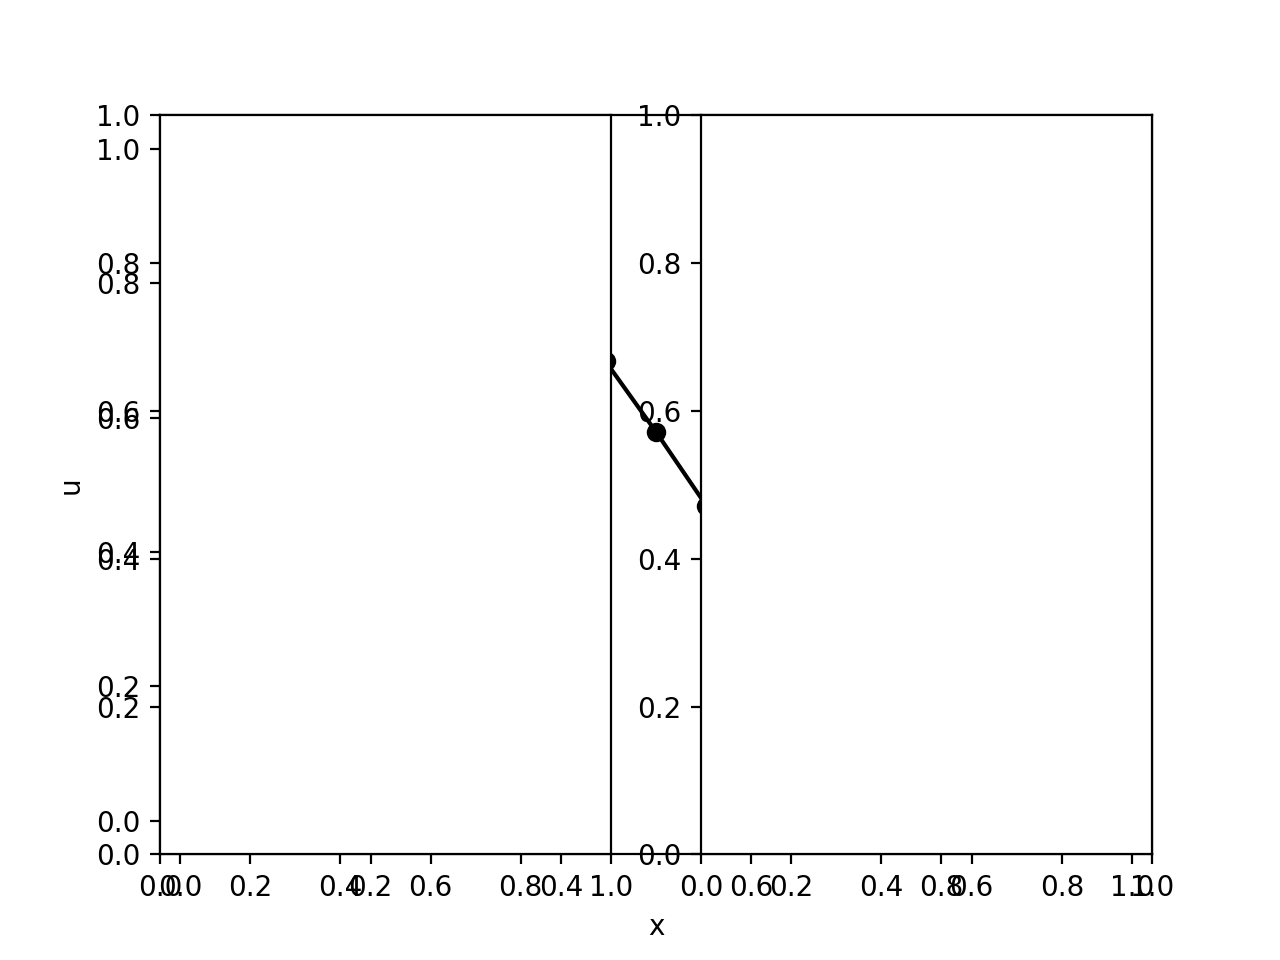

In [4]:
import matplotlib.animation as animation

dt = 0.01
fig = plt.figure()
plt.xlabel('x')
plt.ylabel('u')
ims = []
for i in range(100):
    solver.step(dt, upwind)
    
    # Pick one line
    data = [(np.array(cell.centroid), cell.value) for cell in solver.mesh.cells[:, -1]]
    data = np.asarray(data)  
    x = np.array([x  for x, y in data[:, 0] ])
    val = np.concatenate(data[:, 1])
    ims.append(plt.plot(x, val, 'ko-'))
    ani = animation.ArtistAnimation(fig, ims, interval=10)
ani


# Burgers equation

The method of characteristics, provides a convenient way to calculate the evolution of both $\rho\left(t,\mathbf{x}\right)$ and $\mathbf{u}\left(t,\mathbf{x}\right)$.\\
The Burgers equation can be written as:

$$
\frac{\partial u}{\partial t}+ \frac{\partial}{\partial x}\left(\frac{u^2}{2}\right)=0
$$

That is the Burgers equation for which we know the solution. The density field becomes discontinuous but can be evaluated for all $t \in [0,1)$.\\
Anywhere on $\left(\left.-\infty,-1\right]\right. \cup \left[\left.1,+\infty\right)\right.$, we still have $\rho(t,\mathbf{x})=1 \forall t \in \left[\left. 0,1 \right) \right.$.\\
In the expansion wave, we have:

$$
\frac{D}{Dt}\log \rho = -\frac{\partial u}{\partial x} =\frac{-1}{1+t}
$$so that:

$$
    \rho\left(t,x\right)=\frac{1}{1+t}
$$

with $t\in \left[0,1\right]$ and $x\in\left[t,1\right]$.\\
Considering the mass conservation equation, in the compression wave, we have:

$$
    \frac{D}{Dt}\log\rho = -\frac{\partial u}{\partial x}=\frac{1}{1-t}
$$

so that:

$$
    \rho(t,x)=\frac{1}{1-t}
$$with $t\in\left[0,1\right]$ and $x\in\left[t,1\right]$. It clearely blows-up at $t=1$

# The Rankine-Hugoniot generalized problem

We consider the typical singularity which can appear is a Delta shock, a shock in velocity, accompained with a Dirac delta function in density.\\
At time $t=1$, conserving mass and momentum allows to deduce that the amount of mass, which concentrate in the delta shock is:
$$
    \int_0^1\rho^0(x)\mathrm{d}x=1
$$and the momentum:
$$
    \int_0^1\rho^0(x)u^0(x)\mathrm{d}x=\frac{1}{2}
$$Thus we will start at $t=1$ by a solution given by the theory of characteristics anywhere in $x\in R\setminus\{1\}$ to which one "add" the following function:
$$
    m^1\delta\left(x-p^1\right)
$$
with:
$$
\begin{cases}
    m(1)=m^1=1\\
    p(1)=p^1=1\\
    v(1)=v^1=1
\end{cases}
$$$m(t)$ represents the mass in the delta shock, $p(t)$ its position, $v(t)$ its velocity.\\In order to resolve the dynamics of this singularity, we need generalized Rankine-Hugoniot jump conditions:\begin{align}
\begin{cases}
    \dfrac{d\rho(t)}{dt} &= v(t)\\
    \dfrac{d m(t)}{dt} &= -\left(\rho^{-}-\rho^{+}\right)v(t)+\rho^{-}u^{-}-\rho^{+}u^{+}\\
    \dfrac{d\left(m(t)v(t)\right)}{dt} &= -\left(\rho^{-}u^{-} -\rho^{+}u^{+}\right)v(t)+\rho^{-}\left(u^{-}\right)^2-\rho^{+}\left(u^{+}\right)^2
\end{cases}
\end{align}We will test two conditions:

## Condition 1
$$
\begin{align}
\begin{cases}
    \rho^{+} &= 1\\
    \rho^{-} &=-\frac{1}{1+t}
\end{cases}
\end{align}
$$
$$
\begin{align}
\begin{cases}
    u^{+} &= 0\\
    u^{-} &=\frac{1+p(t)}{1+t}
\end{cases}
\end{align}
$$The system above will become:\begin{align}
\begin{cases}
    \dfrac{d\rho(t)}{dt} &= v(t)\\
    \dfrac{d m(t)}{dt} &= \frac{1}{1+t}\left(tv(t)+\frac{1+p(t)}{1+t}\right)\\
    \dfrac{d\left(m(t)v(t)\right)}{dt} &=\frac{1}{1+t}\left[\frac{1+p(t)}{1+t}-v(t)\right]^2-v(t)^2
\end{cases}
\end{align}

## Condition 2
$$
\begin{align}
\begin{cases}
    \rho^{+} &= 2\\
    \rho^{-} &=\frac{1}{1+t}
\end{cases}
\end{align}
$$
$$
\begin{align}
\begin{cases}
    u^{+} &= 0\\
    u^{-} &=\frac{1+p(t)}{1+t}
\end{cases}
\end{align}
$$The system above will become:\begin{align}
\begin{cases}
    \dfrac{d\rho(t)}{dt} &= v(t)\\
    \dfrac{d m(t)}{dt} &= \frac{1}{1+t}\left(v(t)-\frac{1+p(t)}{1-t}\right)+2v(t)\\
    \dfrac{d\left(m(t)v(t)\right)}{dt} &=\left(\frac{1}{1+t}\right)\left(\frac{1+p(t)}{1+t}\right)\left[v-\frac{1+p(t)}{1+t}\right]
\end{cases}
\end{align}

In [5]:
from scipy.integrate import odeint

def rh_gen(mvp, t, rho_plus):
    m = mvp[0]
    v = mvp[1]
    p = mvp[2]
    
    rho_minus = 1/(1+t)
    u_plus = 0
    u_minus = (1+p)/(1+t)
    mdot = -(rho_minus-rho_plus)*v+rho_minus*u_minus-rho_plus*u_plus
    vdot = 1/m*(-(rho_minus*u_minus-rho_plus*u_plus)*v+rho_minus*u_minus**2-rho_plus*u_plus**2-mdot*v)
    pdot = v
    
    return [mdot, vdot, pdot]

t = np.linspace(1, 15, 1000)

@interact(rho_plus=IntSlider(value=1, min=1, max=2))
def solve_ode(rho_plus):
    sol = odeint(rh_gen, [1, 0.5, 1], t, args=(rho_plus,))
    m = sol[:, 0]
    v = sol[:, 1]
    p = sol[:, 2]


    fig = plt.figure()
    fig.add_subplot(131)
    plt.plot(t,m)
    plt.xlabel("t")
    plt.ylabel("Delta-shock mass")
    
    fig.add_subplot(132)
    plt.plot(t, v)
    plt.xlabel("t")
    plt.ylabel("Delta-shock velocity")
    
    
    fig.add_subplot(133)
    plt.plot(t, p)
    plt.xlabel("t")
    plt.ylabel("Delta-shock position")
    
    fig.tight_layout()
    

interactive(children=(IntSlider(value=1, description='rho_plus', max=2, min=1), Output()), _dom_classes=('widg…

<IPython.core.display.Javascript object>


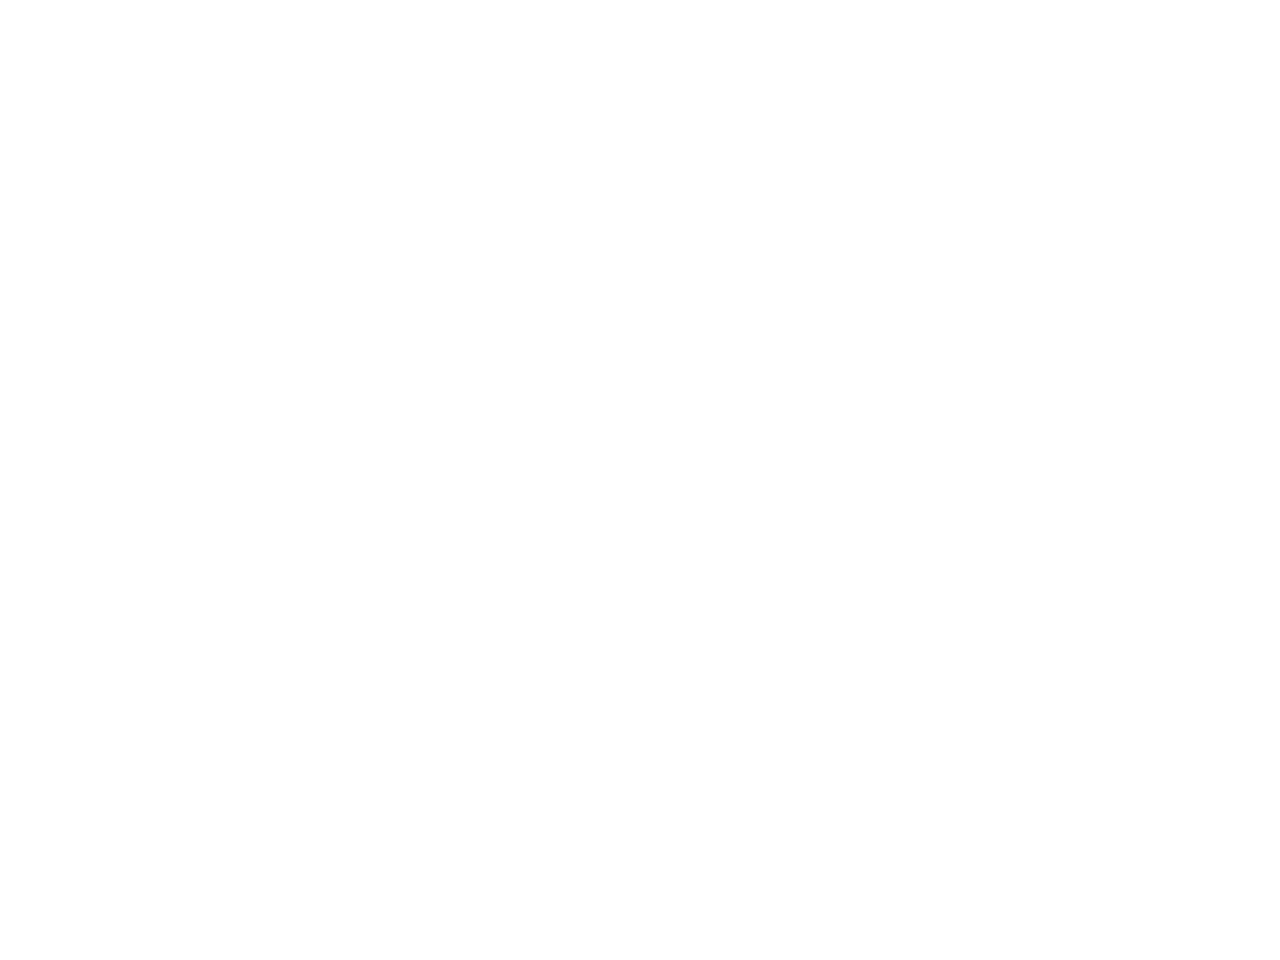

In [17]:
left = Line([-5, 0], [-5, 1])
bottom = Line([-5, 0], [5, 0])
right = Line([5, 0], [5, 1])
top = Line([-5, 1], [5, 1])

left, right = make_periodic(left, right, Direction.X)
bottom, top = make_periodic(bottom, top, Direction.Y)

mesh = Mesh(left, bottom, right, top)
mesh.interpolate(1000, 2)
mesh.generate()

plt.figure()
# mesh.plot()
plt.show()

<IPython.core.display.Javascript object>


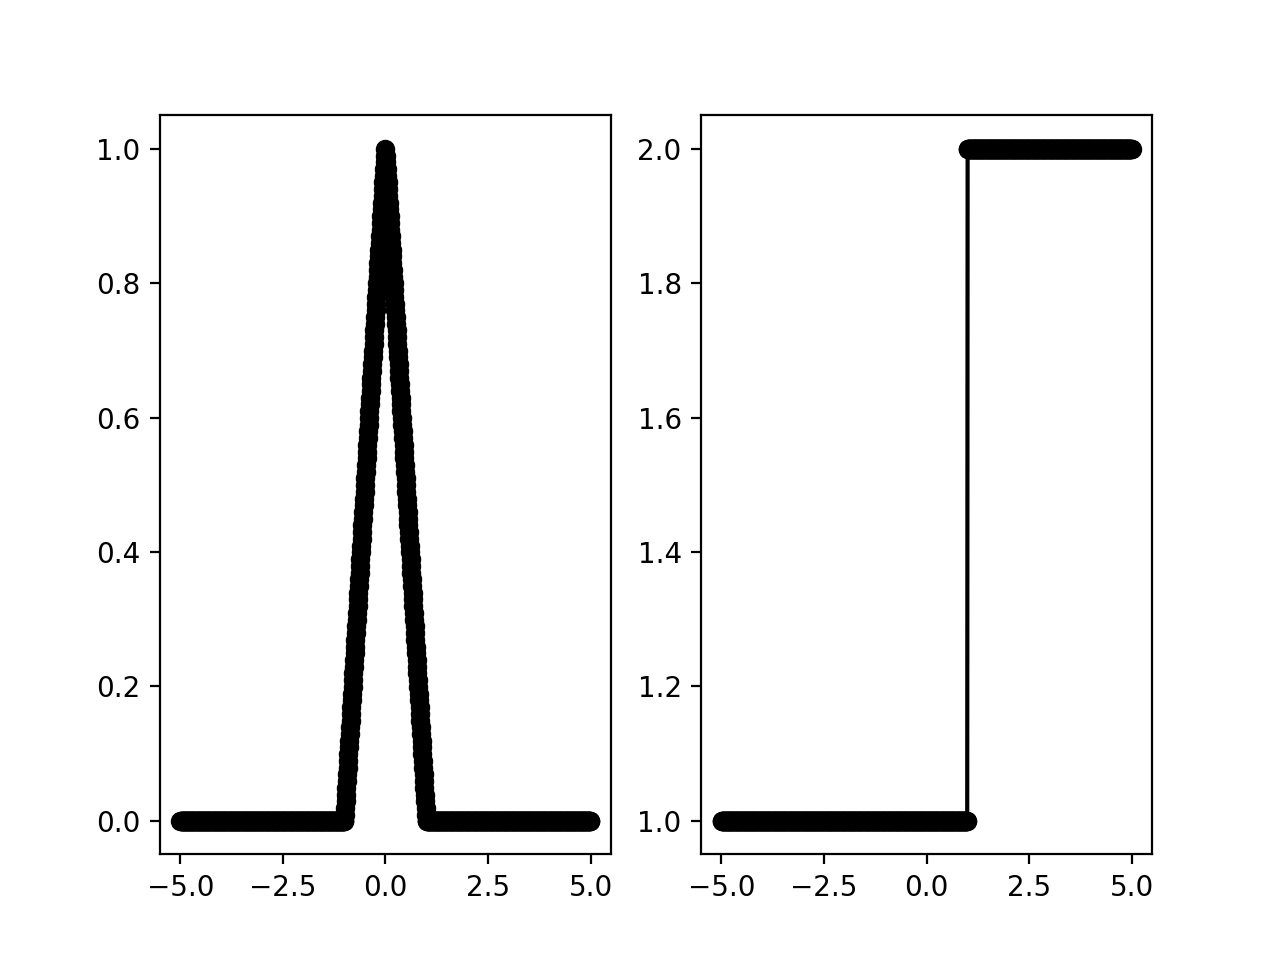

In [18]:
class PGD(Problem):
    Q = StateTemplate("rho", "rhoU", "rhoV")
    @classmethod
    def flux(cls, Q: State) -> np.ndarray:
        U = Q.rhoU/Q.rho
        V = Q.rhoV/Q.rho
        
        return np.array([
            [Q.rhoU, Q.rhoV],
            [Q.rhoU*U, Q.rhoU*V],
            [Q.rhoV*U, Q.rhoV*V]
        ])
    
    
def init(cell: Cell) -> State: 
    xc, yc = cell.centroid
    
    if xc > 1:
        rho = 2
    else: 
        rho = 1
            
    
    if (xc >= -1) and (xc <= 0):
        U = 1 + xc
        V = 0
    elif (xc > 0) and (xc <= 1):
        U = 1 - xc
        V = 0
    else:
        U = 0
        V = 0

    return PGD.Q(rho, rho*U, rho*V)

solver = Solver(mesh, PGD)
solver.init(init)

# Pick one line
data = [(np.array(cell.centroid), cell.value) for cell in solver.mesh.cells[:, -1]]
data = np.asarray(data)
x = np.array([x  for x, y in data[:, 0] ])
u = [s.rhoU/s.rho for s in data[:, 1]]
rho = [s.rho for s in data[:, 1]]
fig = plt.figure()
fig.add_subplot(121)
plt.plot(x, u, 'ko-')
fig.add_subplot(122)
plt.plot(x, rho, 'ko-')

In [19]:
def godunov(cell):
    Q = solver.problem.Q(0, 0, 0)
    
    rho_cell = cell.value.rho
    rhoU_cell = cell.value.rhoU
    rhoV_cell = cell.value.rhoV
    
    U_cell = rhoU_cell/rho_cell
    V_cell = rhoV_cell/rho_cell
    
    
    UU_cell = np.array([U_cell, V_cell])

    for neigh in cell:        
        norm = neigh.face.normal
        flux = solver.problem.flux
        S = neigh.face.surface
        
        rho_neigh = neigh.value.rho
        rhoU_neigh = neigh.value.rhoU
        rhoV_neigh = neigh.value.rhoV
    
        U_neigh = rhoU_neigh/rho_neigh
        V_neigh = rhoV_neigh/rho_neigh
        
        UU_neigh = np.array([U_neigh, V_neigh])
        
        un_cell = UU_cell.dot(norm)
        un_neigh = UU_neigh.dot(norm)
        
        sqrtrho_cell = np.sqrt(rho_cell)
        sqrtrho_neigh = np.sqrt(rho_neigh)
        
        num = sqrtrho_cell*U_cell + sqrtrho_neigh*U_neigh
        den = sqrtrho_cell + sqrtrho_neigh
                
        u_delta = num/den

        if un_cell >= un_neigh:
            if u_delta > 0:
                Q = Q + flux(cell.value).dot(norm)*S
            elif u_delta < 0:
                Q = Q + flux(neigh.value).dot(norm)*S
            else:
                Q_mean = (cell.value + neigh.value)/2
                Q = Q + flux(Q_mean).dot(norm)*S        
        else:
            if un_cell > 0:
                Q = Q + flux(cell.value).dot(norm)*S
            elif un_neigh < 0:
                Q = Q + flux(neigh.value).dot(norm)*S
            else:
                pass


    return Q



<IPython.core.display.Javascript object>


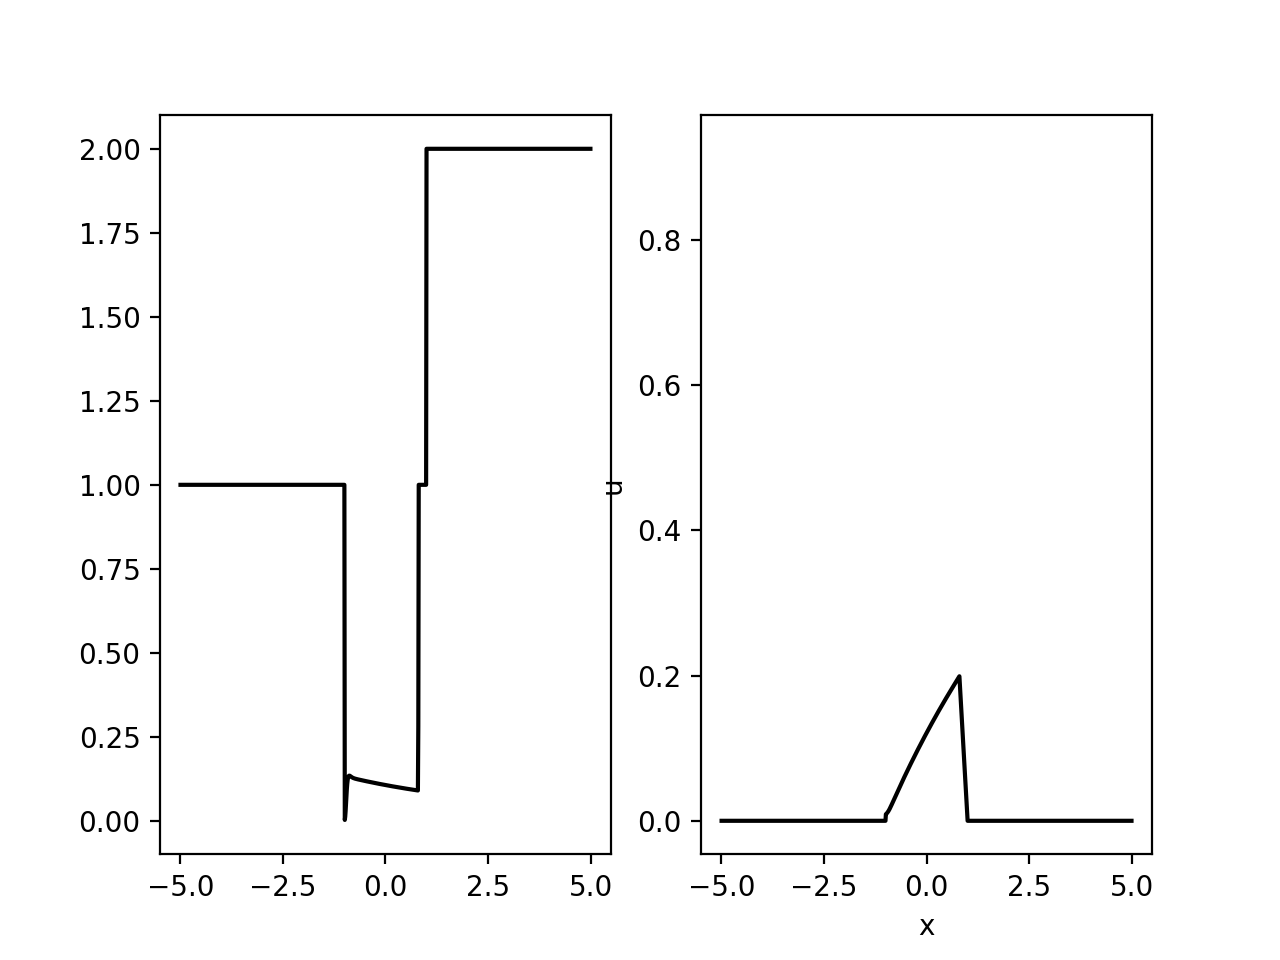

t:0, dt:0.01
t:0.01, dt:0.01
t:0.02, dt:0.01
t:0.03, dt:0.01
t:0.04, dt:0.01
t:0.05, dt:0.01
t:0.060000000000000005, dt:0.01
t:0.07, dt:0.01
t:0.08, dt:0.01
t:0.09, dt:0.01
t:0.09999999999999999, dt:0.01
t:0.10999999999999999, dt:0.01
t:0.11999999999999998, dt:0.01
t:0.12999999999999998, dt:0.01
t:0.13999999999999999, dt:0.01
t:0.15, dt:0.01
t:0.16, dt:0.01
t:0.17, dt:0.01
t:0.18000000000000002, dt:0.01
t:0.19000000000000003, dt:0.01
t:0.20000000000000004, dt:0.01
t:0.21000000000000005, dt:0.01
t:0.22000000000000006, dt:0.01
t:0.23000000000000007, dt:0.01
t:0.24000000000000007, dt:0.01
t:0.25000000000000006, dt:0.01
t:0.26000000000000006, dt:0.01
t:0.2700000000000001, dt:0.01
t:0.2800000000000001, dt:0.01
t:0.2900000000000001, dt:0.01
t:0.3000000000000001, dt:0.01
t:0.3100000000000001, dt:0.01
t:0.3200000000000001, dt:0.01
t:0.3300000000000001, dt:0.01
t:0.34000000000000014, dt:0.01
t:0.35000000000000014, dt:0.01
t:0.36000000000000015, dt:0.01
t:0.37000000000000016, dt:0.01
t:0.3800000

t:2.809999999999984, dt:0.01
t:2.819999999999984, dt:0.01
t:2.8299999999999836, dt:0.01
t:2.8399999999999834, dt:0.01
t:2.849999999999983, dt:0.01
t:2.859999999999983, dt:0.01
t:2.869999999999983, dt:0.01
t:2.8799999999999826, dt:0.01
t:2.8899999999999824, dt:0.01
t:2.899999999999982, dt:0.01
t:2.909999999999982, dt:0.01
t:2.9199999999999817, dt:0.01
t:2.9299999999999815, dt:0.01
t:2.9399999999999813, dt:0.01
t:2.949999999999981, dt:0.01
t:2.959999999999981, dt:0.01
t:2.9699999999999807, dt:0.01
t:2.9799999999999804, dt:0.01
t:2.9899999999999802, dt:0.01
t:2.99999999999998, dt:0.01
t:3.00999999999998, dt:0.01
t:3.0199999999999796, dt:0.01
t:3.0299999999999794, dt:0.01
t:3.039999999999979, dt:0.01
t:3.049999999999979, dt:0.01
t:3.0599999999999787, dt:0.01
t:3.0699999999999785, dt:0.01
t:3.0799999999999783, dt:0.01
t:3.089999999999978, dt:0.01
t:3.099999999999978, dt:0.01
t:3.1099999999999777, dt:0.01
t:3.1199999999999775, dt:0.01
t:3.1299999999999772, dt:0.01
t:3.139999999999977, dt:0.0

t:5.619999999999925, dt:0.01
t:5.629999999999924, dt:0.01
t:5.639999999999924, dt:0.01
t:5.649999999999924, dt:0.01
t:5.659999999999924, dt:0.01
t:5.6699999999999235, dt:0.01
t:5.679999999999923, dt:0.01
t:5.689999999999923, dt:0.01
t:5.699999999999923, dt:0.01
t:5.709999999999923, dt:0.01
t:5.7199999999999225, dt:0.01
t:5.729999999999922, dt:0.01
t:5.739999999999922, dt:0.01
t:5.749999999999922, dt:0.01
t:5.759999999999922, dt:0.01
t:5.769999999999921, dt:0.01
t:5.779999999999921, dt:0.01
t:5.789999999999921, dt:0.01
t:5.799999999999921, dt:0.01
t:5.809999999999921, dt:0.01
t:5.81999999999992, dt:0.01
t:5.82999999999992, dt:0.01
t:5.83999999999992, dt:0.01
t:5.84999999999992, dt:0.01
t:5.8599999999999195, dt:0.01
t:5.869999999999919, dt:0.01
t:5.879999999999919, dt:0.01
t:5.889999999999919, dt:0.01
t:5.899999999999919, dt:0.01
t:5.909999999999918, dt:0.01
t:5.919999999999918, dt:0.01
t:5.929999999999918, dt:0.01
t:5.939999999999918, dt:0.01
t:5.949999999999918, dt:0.01
t:5.95999999999

t:8.449999999999864, dt:0.01
t:8.459999999999864, dt:0.01
t:8.469999999999864, dt:0.01
t:8.479999999999864, dt:0.01
t:8.489999999999863, dt:0.01
t:8.499999999999863, dt:0.01
t:8.509999999999863, dt:0.01
t:8.519999999999863, dt:0.01
t:8.529999999999863, dt:0.01
t:8.539999999999862, dt:0.01
t:8.549999999999862, dt:0.01
t:8.559999999999862, dt:0.01
t:8.569999999999862, dt:0.01
t:8.579999999999862, dt:0.01
t:8.589999999999861, dt:0.01
t:8.599999999999861, dt:0.01
t:8.60999999999986, dt:0.01
t:8.61999999999986, dt:0.01
t:8.62999999999986, dt:0.01
t:8.63999999999986, dt:0.01
t:8.64999999999986, dt:0.01
t:8.65999999999986, dt:0.01
t:8.66999999999986, dt:0.01
t:8.67999999999986, dt:0.01
t:8.68999999999986, dt:0.01
t:8.699999999999859, dt:0.01
t:8.709999999999859, dt:0.01
t:8.719999999999859, dt:0.01
t:8.729999999999858, dt:0.01
t:8.739999999999858, dt:0.01
t:8.749999999999858, dt:0.01
t:8.759999999999858, dt:0.01
t:8.769999999999857, dt:0.01
t:8.779999999999857, dt:0.01
t:8.789999999999857, dt

In [20]:
t = 0
dt = 0.01
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.xlabel('x')
plt.ylabel('u')
ims = []
out = []
solver.init(init)
for i in range(1000):
    print(f't:{t}, dt:{dt}')
    solver.step(dt, godunov)
    t = t + dt

    
    # Pick one line
    data = [(np.array(cell.centroid), cell.value) for cell in solver.mesh.cells[:, -1]]
    data = np.asarray(data)
    x = np.array([x  for x, y in data[:, 0] ])
    
    rho = [s.rho for s in data[:, 1]]
    im1, = ax1.plot(x, rho, 'k-')
    
    U = [s.rhoU/s.rho for s in data[:, 1]]
    out.append((rho, U))
    im2, = ax2.plot(x, U, 'k-')
    ims.append([im1, im2])
ani = animation.ArtistAnimation(fig, ims, interval=1)
ani